# CloudArch Part 1 Visualizations

1. Using the instructions above, run memcached alone (i.e., no interference), and with each iBench source of interference (cpu, l1d, l1i, l2, llc, membw). 
2. Plot a single line graph with 95th percentile latency on the y-axis (the y-axis should range from 0 to 10 ms) and QPS on the x-axis (the x-axis should range from 0 to 55K) for each configuration (7 lines in total). 
    - Label your axes. 
    - State how many runs you averaged across (we recommend a minimum of 3).
    - Include error bars. 
    
The readability of your plot will be part of your grade.

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

%matplotlib inline

## Read Measurements

In [2]:
RESULTS_PATH = 'results/'

In [3]:
def load_config_results(result_dir, config):
    """
    Given a directory which corresponds to the results from a configuration,
    read the measurements from each repetition.
        
    Return a DataFrame containing the mean/standard error of the 95th percentile latency and QPS.
    """
    latency_df = pd.DataFrame()
    qps_df = pd.DataFrame()
    
    config_dir = os.path.join(result_dir, config)
    
    for rep in (rep for rep in os.listdir(config_dir) if rep != '.DS_Store'):
        path = os.path.join(config_dir, rep, 'measurements.dat')
        rep_df = pd.read_csv(path, sep=' ', header=0, names=['95P Latency', 'QPS'])
        
        latency_df[rep] = rep_df['95P Latency'] / 1000 # convert microseconds to ms
        qps_df[rep] = rep_df['QPS']
        
    config_df = pd.DataFrame()

    config_df['95P Latency Mean'] = latency_df.mean(axis=1)
    config_df['95P Latency SEM'] = latency_df.sem(axis=1)
    
    config_df['QPS Mean'] = qps_df.mean(axis=1)
    config_df['QPS SEM'] = qps_df.std(axis=1)
    
    config_df['Config'] = config
        
    return config_df

In [4]:
# Concat a results dataframe with all the information we need
results_df = pd.DataFrame()

for config in os.listdir(RESULTS_PATH):
    config_df = load_config_results(RESULTS_PATH, config)
    
    results_df = pd.concat([results_df, config_df])
    
results_df

,95P Latency Mean,95P Latency SEM,QPS Mean,QPS SEM,Config
0,3.98366,0.027387,4990.64,41.352555,intf_ibench-l1i
1,3.67003,0.020306,9961.64,55.335807,intf_ibench-l1i
2,3.38701,0.018957,14972.36,59.611617,intf_ibench-l1i
3,3.44453,0.199230,20017.78,62.677265,intf_ibench-l1i
4,4.75504,0.219545,24988.06,63.401581,intf_ibench-l1i
...,...,...,...,...,...
6,1.55575,0.041141,35016.55,90.420465,intf_ibench-l2
7,1.52775,0.025218,39968.52,84.955437,intf_ibench-l2
8,1.61155,0.043885,44956.30,64.952444,intf_ibench-l2
9,1.80903,0.097418,49769.78,374.440305,intf_ibench-l2


In [5]:
results_df[results_df['Config'] == 'intf_ibench-l1i']

,95P Latency Mean,95P Latency SEM,QPS Mean,QPS SEM,Config
0,3.98366,0.027387,4990.64,41.352555,intf_ibench-l1i
1,3.67003,0.020306,9961.64,55.335807,intf_ibench-l1i
2,3.38701,0.018957,14972.36,59.611617,intf_ibench-l1i
3,3.44453,0.199230,20017.78,62.677265,intf_ibench-l1i
4,4.75504,0.219545,24988.06,63.401581,intf_ibench-l1i
5,8.09533,0.383487,27286.66,843.353433,intf_ibench-l1i
6,8.91685,0.235419,27008.48,1163.219220,intf_ibench-l1i
7,8.81306,0.265035,27012.06,1144.934781,intf_ibench-l1i
8,8.71512,0.270504,26858.36,1080.432995,intf_ibench-l1i
9,8.78053,0.272771,26843.11,1052.373931,intf_ibench-l1i


## Plot Measurements
Using seaborn with error bars as standard error from the sample mean.

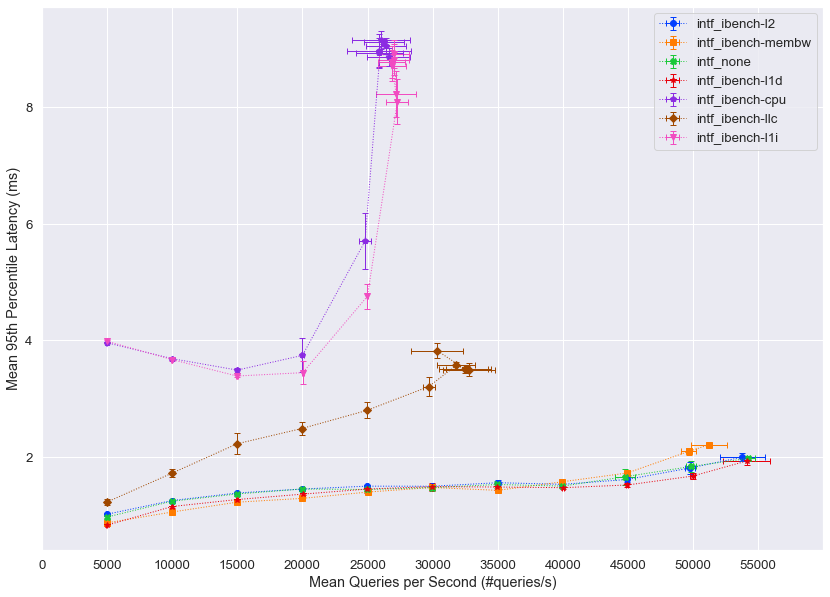

In [15]:
sns.set(style='darkgrid', font_scale=1.2)
sns.set_palette(sns.color_palette('bright'))
fig, ax = plt.subplots(figsize=(14,10))

# Titles
plt.ylabel('Mean 95th Percentile Latency (ms)')
plt.xlabel('Mean Queries per Second (#queries/s)')

# Format X-Axis
plt.xticks(range(0, 55001, 5000))
ax.set_xlim([0, 60000])

# Different marker per line
markers = ['o', 's', 'X', '*', 'p', 'D', 'v']

for config, marker in zip(reversed(results_df['Config'].unique()), markers):
    idf = results_df[results_df['Config'] == config]
    ax.errorbar(x=idf['QPS Mean'], 
                y=idf['95P Latency Mean'], 
                yerr = idf['95P Latency SEM'], 
                xerr = idf['QPS SEM'], 
                label=config, 
                fmt='{}:'.format(marker), 
                capsize=3, capthick=1, elinewidth=1, 
                linewidth=1)
    
ax.legend()

plt.savefig('part1_plot.png')